<a href="https://colab.research.google.com/github/Ssuche/capstone/blob/classification/3_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tensorflow
# some package install
# !pip install pandas

In [ ]:

#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Import classification_report
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge,ElasticNet
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from IPython.display import display


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#read the merge data
ToTMerge = pd.read_csv("/content/drive/My Drive/Capstone/All Dataset& Resource/merged_data.csv")
#drop some irrelevant columns from david's email
ToTMerge= ToTMerge.drop(columns=["dm_on_pmh","chem_gluc","chem_creat","match_type"])
ToTMerge.head()
#print(ToTMerge.columns.unique())


,encrypt_mrn,ed_screened,visit_date,new_diagnosis,pcp_followup,max_sbp,min_dbp,max_diff,avg_sbp,avg_dbp,...,max_value_HEMOGLOBIN A1C,"max_value_LDL CHOLESTEROL, CALCULATED","min_value_CHOLESTEROL, TOTAL",min_value_CREATININE,min_value_GLUCOSE,"min_value_GLUCOSE, POC",min_value_HDL CHOLESTEROL,min_value_HEMOGLOBIN A1C,"min_value_LDL CHOLESTEROL, CALCULATED",visit_type
0,2303579,NYU Brooklyn,2023-01-10,Yes,Yes,133.0,64.0,52.0,122.25,79.25,...,9.3,176.0,268.0,0.74,305.0,230.0,31.0,9.3,176.0,Hospitalization
1,2117042,NYU Long Island,2022-01-13,Yes,Yes,102.0,69.0,33.0,102.00,69.00,...,NaN,NaN,NaN,NaN,NaN,443.0,NaN,NaN,NaN,Hospitalization
2,2117326,NYU Brooklyn,2022-01-14,Yes,No,158.0,82.0,76.0,153.00,85.00,...,11.2,NaN,NaN,0.70,423.0,404.0,NaN,11.2,NaN,Emergency
3,2112782,NYU Brooklyn,2022-01-16,Yes,No,181.0,87.0,88.0,163.50,90.00,...,11.6,NaN,NaN,1.03,418.0,491.0,NaN,11.6,NaN,Emergency
4,2062174,NYU Cobble Hill,2022-01-19,Yes,Yes,177.0,68.0,77.0,155.50,84.75,...,8.3,NaN,NaN,NaN,NaN,181.0,NaN,8.3,NaN,Emergency


In [ ]:
print(ToTMerge.shape)
print(ToTMerge.dtypes)

(254, 148)
encrypt_mrn                                int64
ed_screened                               object
visit_date                                object
new_diagnosis                             object
pcp_followup                              object
                                          ...   
min_value_GLUCOSE, POC                   float64
min_value_HDL CHOLESTEROL                float64
min_value_HEMOGLOBIN A1C                 float64
min_value_LDL CHOLESTEROL, CALCULATED    float64
visit_type                                object
Length: 148, dtype: object


In [ ]:
# 1️⃣ 自动检测所有文本列
text_columns = ToTMerge.select_dtypes(include=['object']).columns

# 2️⃣ 使用 LabelEncoder 转换每个文本列
label_encoders = {}
for col in text_columns:
    le = LabelEncoder()
    ToTMerge[col] = le.fit_transform(ToTMerge[col])  # 将文本列转换为整数
    label_encoders[col] = le  # 存储编码器，以便后续解码

# 检查转换结果
print(ToTMerge.head())


   encrypt_mrn  ed_screened  visit_date  new_diagnosis  pcp_followup  max_sbp  \
0      2303579            0         133              0             1    133.0   
1      2117042            2           2              0             1    102.0   
2      2117326            0           3              0             0    158.0   
3      2112782            0           4              0             0    181.0   
4      2062174            1           5              0             1    177.0   

   min_dbp  max_diff  avg_sbp  avg_dbp  ...  max_value_HEMOGLOBIN A1C  \
0     64.0      52.0   122.25    79.25  ...                       9.3   
1     69.0      33.0   102.00    69.00  ...                       NaN   
2     82.0      76.0   153.00    85.00  ...                      11.2   
3     87.0      88.0   163.50    90.00  ...                      11.6   
4     68.0      77.0   155.50    84.75  ...                       8.3   

   max_value_LDL CHOLESTEROL, CALCULATED  min_value_CHOLESTEROL, TOTAL  \


In [ ]:
#check point of NAN
ToTMerge.shape
print(ToTMerge.isnull().sum())

encrypt_mrn                                0
ed_screened                                0
visit_date                                 0
new_diagnosis                              0
pcp_followup                               0
                                        ... 
min_value_GLUCOSE, POC                   131
min_value_HDL CHOLESTEROL                239
min_value_HEMOGLOBIN A1C                  24
min_value_LDL CHOLESTEROL, CALCULATED    242
visit_type                                 0
Length: 148, dtype: int64


In [ ]:

ToTMerge = ToTMerge.fillna(0)


In [ ]:
#some EDA
X = ToTMerge.drop(columns=["pcp_followup"])  # select all features
y = ToTMerge["pcp_followup"]  # target variable



#  70% train, 30% text
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# print shape
print(" X_train:", X_train.shape)
print(" y_train:", y_train.shape)
print(" X_test:", X_test.shape)
print(" y_test:", y_test.shape)





 X_train: (177, 147)
 y_train: (177,)
 X_test: (77, 147)
 y_test: (77,)


In [ ]:
#Exploration EDA
# plt.figure(figsize = (10, 10))
# sns.heatmap(ToTMerge.corr(), annot = True)
#***the result have too many features, i will use pca in the model***


# # Drop the target column (e.g., "Outcome") and standardize the feature values
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)  # Standardizing only features

# # Apply PCA and reduce to 10 principal components
# pca = PCA(n_components=10)  # Keeping the top 10 components
# X_pca = pca.fit_transform(X_scaled)

# # Check explained variance ratio
# print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# # Convert PCA results into a DataFrame
# pca_df = pd.DataFrame(X_pca, columns=[f"PCA_{i+1}" for i in range(10)])

# # Compute the correlation matrix for the principal components
# pca_corr_matrix = pd.DataFrame(X_pca).corr()

# # Plot the heatmap of the reduced features
# plt.figure(figsize=(12, 8))
# sns.heatmap(pca_corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
# plt.title("Correlation Heatmap of PCA-Reduced Features")
# plt.show()
# 解决下降维问题 pca is not available

Tha Best Alpha and L1_ratio

In [ ]:
# #select the best alpha(because it is the small dataset volume, we also can use the RidgeCV or ElasticNetCV
# param_grid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}

# ridge_cv = GridSearchCV(Ridge(), param_grid, cv=5, scoring="neg_mean_squared_error")
# ridge_cv.fit(X_train, y_train)
# lasso_cv = GridSearchCV(Lasso(), param_grid, cv=5, scoring="neg_mean_squared_error")
# lasso_cv.fit(X_train, y_train)

# param_grid={"alpha":[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     "l1_ratio":[0.1, 0.3, 0.5, 0.7, 0.9, 1]}
# elasticnet_cv = GridSearchCV(ElasticNet(max_iter=5000), param_grid, cv=5, scoring="neg_mean_squared_error")
# elasticnet_cv.fit(X_train, y_train)

# # output the best alpha
# print(f"ElasticNet the best alpha: {elasticnet_cv.best_params_['alpha']}")
# print(f"ElasticNet the best l1_ratio: {elasticnet_cv.best_params_['l1_ratio']}")
# print(f"Lasso best alpha: {lasso_cv.best_params_['alpha']}")
# print(f"Ridge best alpha: {ridge_cv.best_params_['alpha']}")

LASSO MODEL

In [ ]:
# train the lasso model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Make predictions
y_pred_lasso = lasso.predict(X_test)
# Evaluate model performance
lasso_mse = mean_squared_error(y_test, y_pred_lasso)

print(f"lasso Model MSE: {lasso_mse:.4f}")


lasso Model MSE: 0.1586


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.207e+01, tolerance: 2.808e-03
  model = cd_fast.enet_coordinate_descent(


In [ ]:

# Get feature names and corresponding Lasso coefficients
feature_names = np.array(X.columns)
lasso_coeffs = lasso.coef_

# Select only important features (non-zero coefficients)
important_features = feature_names[np.abs(lasso_coeffs) > 0]
important_coeffs = lasso_coeffs[np.abs(lasso_coeffs) > 0]

# Sort by absolute importance (descending order)
sorted_indices = np.argsort(np.abs(important_coeffs))[::-1]
Limportant_features = important_features[sorted_indices]
Limportant_coeffs = important_coeffs[sorted_indices]

# Print the top 10 most important features
for i in range(min(10, len(Limportant_features))):
    print(f"Feature: {Limportant_features[i]}, Coeff: {Limportant_coeffs[i]:.4f}")



Feature: dbp_1st, Coeff: 0.0047
Feature: age, Coeff: 0.0030
Feature: avg_dbp, Coeff: -0.0025
Feature: avg_diff, Coeff: 0.0012
Feature: hba1c, Coeff: 0.0011
Feature: min_value_GLUCOSE, POC, Coeff: -0.0011
Feature: max_sbp, Coeff: 0.0010
Feature: chiefcomplaint, Coeff: -0.0009
Feature: weight, Coeff: 0.0007
Feature: avg_value_LDL CHOLESTEROL, CALCULATED, Coeff: 0.0006


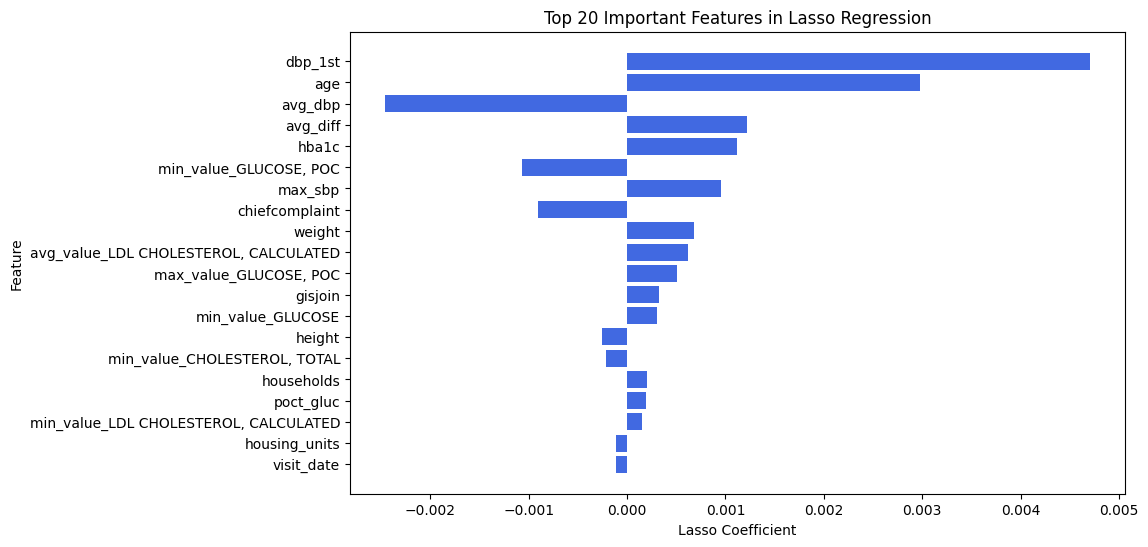

In [ ]:
# Visualize the top important features
plt.figure(figsize=(10, 6))
plt.barh(Limportant_features[:20], Limportant_coeffs[:20], color="royalblue")
plt.xlabel("Lasso Coefficient")
plt.ylabel("Feature")
plt.title("Top 20 Important Features in Lasso Regression")
plt.gca().invert_yaxis()
plt.show()


Ridge Model

In [ ]:
# Train Ridge regression
ridge = Ridge(alpha=100000)  # You can adjust alpha for regularization strength
ridge.fit(X_train, y_train)

# Make predictions
y_pred_ridge = ridge.predict(X_test)

# Evaluate model performance
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
print(f"Ridge Model MSE: {ridge_mse:.4f}")

Ridge Model MSE: 0.1556


In [ ]:
# Get feature names and corresponding Ridge coefficients
feature_names = np.array(X.columns)
ridge_coeffs = ridge.coef_

# Sort by absolute importance (descending order)
sorted_indices = np.argsort(np.abs(ridge_coeffs))[::-1]
Rimportant_features = feature_names[sorted_indices]
Rimportant_coeffs = ridge_coeffs[sorted_indices]

# Print the top 10 most important features
for i in range(min(10, len(Rimportant_features))):
    print(f"Feature: {Rimportant_features[i]}, Coeff: {Rimportant_coeffs[i]:.4f}")


Feature: dbp_1st, Coeff: 0.0007
Feature: min_value_GLUCOSE, POC, Coeff: -0.0007
Feature: max_sbp, Coeff: 0.0006
Feature: weight, Coeff: 0.0005
Feature: max_value_GLUCOSE, POC, Coeff: 0.0004
Feature: age, Coeff: 0.0004
Feature: gisjoin, Coeff: 0.0004
Feature: chiefcomplaint, Coeff: -0.0004
Feature: avg_diff, Coeff: 0.0003
Feature: max_value_LDL CHOLESTEROL, CALCULATED, Coeff: 0.0003


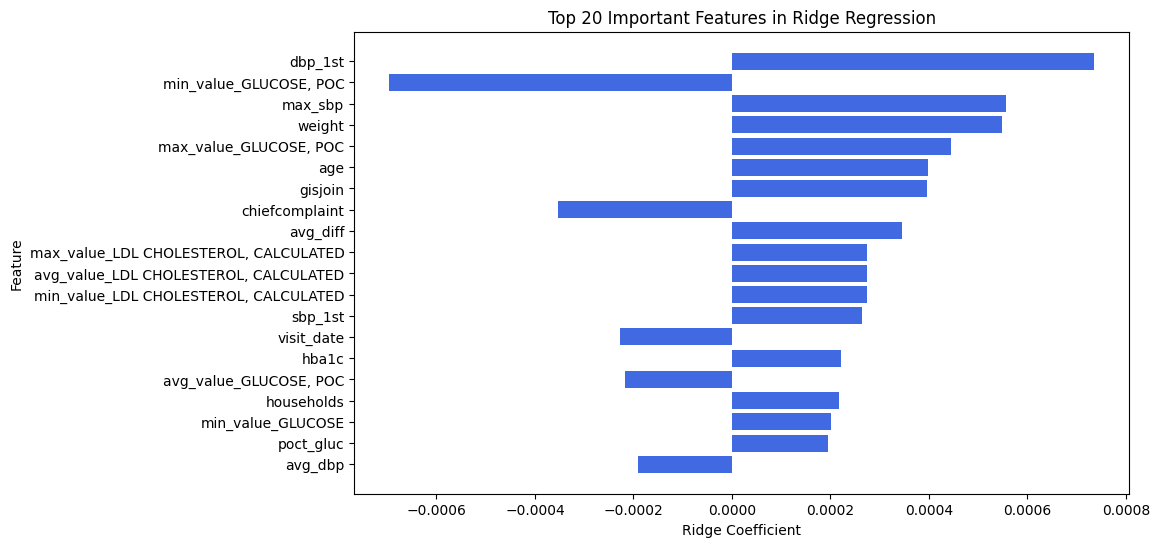

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(Rimportant_features[:20], Rimportant_coeffs[:20], color="royalblue")
plt.xlabel("Ridge Coefficient")
plt.ylabel("Feature")
plt.title("Top 20 Important Features in Ridge Regression")
plt.gca().invert_yaxis()  # Place the most important feature at the top
plt.show()


In [ ]:
# Train ElasticNet model
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)  # Adjust alpha & l1_ratio as needed
elasticnet.fit(X_train, y_train)

# Make predictions
y_pred_elasticnet = elasticnet.predict(X_test)

# Evaluate model performance
elasticnet_mse = mean_squared_error(y_test, y_pred_elasticnet)
print(f"ElasticNet Model MSE: {elasticnet_mse:.4f}")

ElasticNet Model MSE: 0.1638


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.190e+01, tolerance: 2.808e-03
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# Get feature names and corresponding ElasticNet coefficients
feature_names = np.array(X.columns)
elasticnet_coeffs = elasticnet.coef_

# Select only important features (non-zero coefficients)
important_features = feature_names[np.abs(elasticnet_coeffs) > 0]
important_coeffs = elasticnet_coeffs[np.abs(elasticnet_coeffs) > 0]

# Sort by absolute importance (descending order)
sorted_indices = np.argsort(np.abs(important_coeffs))[::-1]
Eimportant_features = important_features[sorted_indices]
Eimportant_coeffs = important_coeffs[sorted_indices]

# Print the top 10 most important features
for i in range(min(10, len(Eimportant_features))):
    print(f"Feature: {Eimportant_features[i]}, Coeff: {Eimportant_coeffs[i]:.4f}")

Feature: tobacco_user, Coeff: -0.0108
Feature: avg_dbp, Coeff: -0.0065
Feature: dbp_1st, Coeff: 0.0059
Feature: hba1c, Coeff: 0.0047
Feature: max_sbp, Coeff: 0.0041
Feature: age, Coeff: 0.0037
Feature: max_diff, Coeff: -0.0034
Feature: avg_diff, Coeff: 0.0024
Feature: max_value_HDL CHOLESTEROL, Coeff: -0.0015
Feature: arrival_date, Coeff: -0.0011


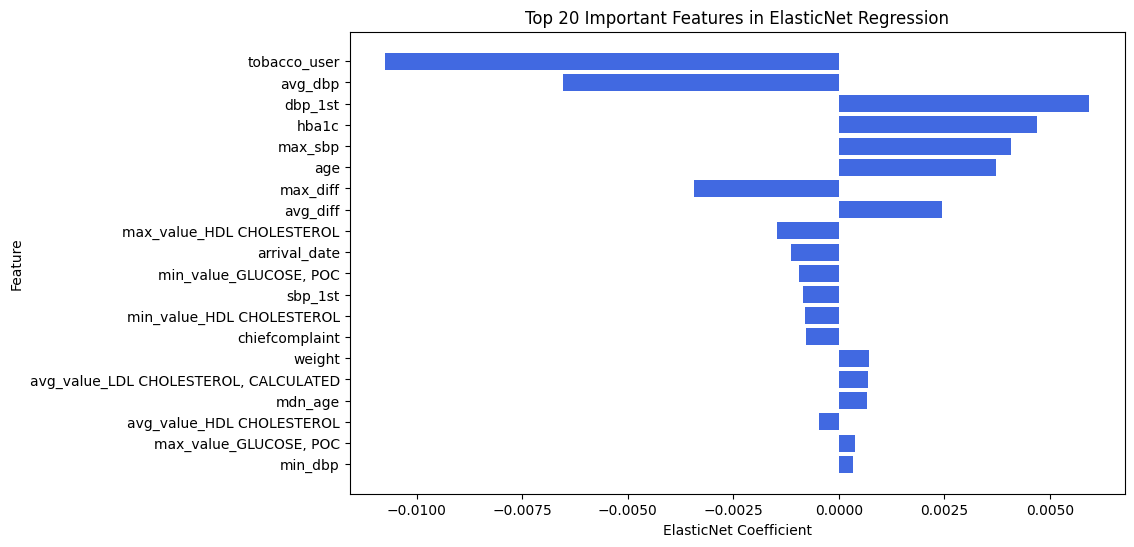

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(Eimportant_features[:20], Eimportant_coeffs[:20], color="royalblue")
plt.xlabel("ElasticNet Coefficient")
plt.ylabel("Feature")
plt.title("Top 20 Important Features in ElasticNet Regression")
plt.gca().invert_yaxis()  # Place the most important feature at the top
plt.show()

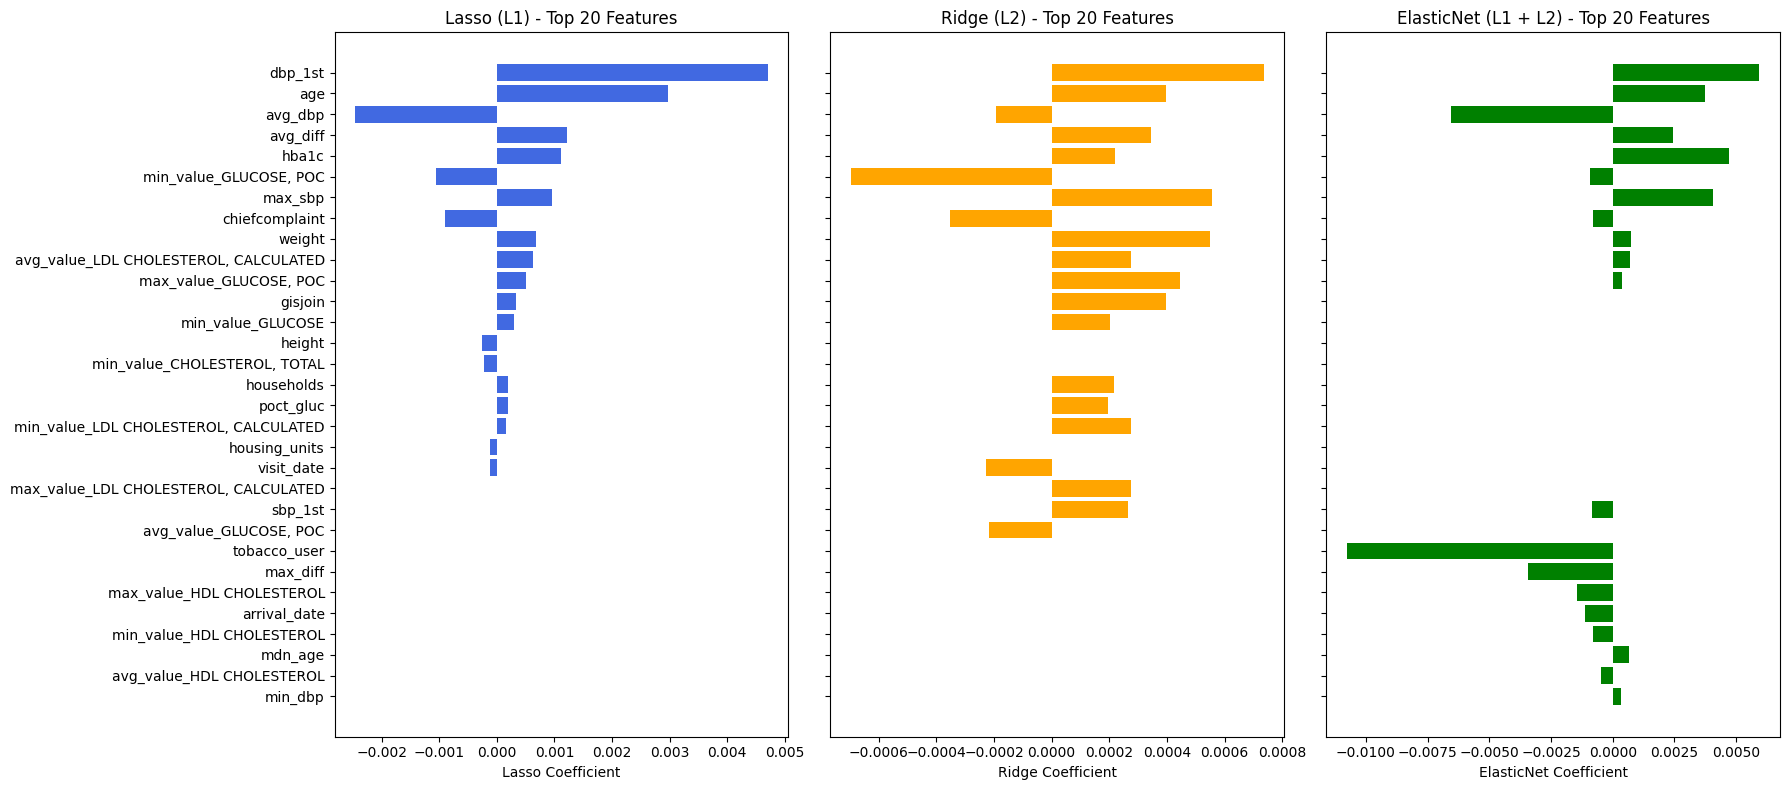

In [ ]:
# integrate to graph the 3 regression model
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

# Lasso regression important features
axes[0].barh(Limportant_features[:20], Limportant_coeffs[:20], color="royalblue")
axes[0].set_title("Lasso (L1) - Top 20 Features")
axes[0].set_xlabel("Lasso Coefficient")
axes[0].invert_yaxis()

# Ridge regression important features
axes[1].barh(Rimportant_features[:20], Rimportant_coeffs[:20], color="orange")
axes[1].set_title("Ridge (L2) - Top 20 Features")
axes[1].set_xlabel("Ridge Coefficient")

# ElasticNet regression important features
axes[2].barh(Eimportant_features[:20], Eimportant_coeffs[:20], color="green")
axes[2].set_title("ElasticNet (L1 + L2) - Top 20 Features")
axes[2].set_xlabel("ElasticNet Coefficient")

plt.tight_layout()
plt.show()

In [ ]:
# Compute R² scores
r2_lasso = r2_score(y_test, y_pred_lasso)
r2_ridge = r2_score(y_test, y_pred_ridge)
r2_elastic = r2_score(y_test, y_pred_elasticnet)

In [ ]:


# Create a dictionary with results
results_dict = {
    "Model": ["Lasso", "Ridge", "ElasticNet"],
    "R² Score": [r2_lasso, r2_ridge, r2_elastic],
    "MSE": [lasso_mse, ridge_mse, elasticnet_mse]
}

# Convert to a DataFrame
results_df = pd.DataFrame(results_dict)

# Display the tabledisplay(results_df)

In [ ]:
# print(classiciation_report(y_test, y_pred_lasso))
# print(classiciation_report(y_test, y_pred_ridge))# print(classiciation_report(y_test, y_pred_elasticnet))

# New Section
Deep learning in this project

In [ ]:
#read the merge data
ToTMerge = pd.read_csv("/content/drive/My Drive/Capstone/All Dataset& Resource/merged_data.csv")
#drop some irrelevant columns from david's email
ToTMerge= ToTMerge.drop(columns=["dm_on_pmh","chem_gluc","chem_creat","match_type"])
ToTMerge.head()
#print(ToTMerge.columns.unique())


,encrypt_mrn,ed_screened,visit_date,new_diagnosis,pcp_followup,max_sbp,min_dbp,max_diff,avg_sbp,avg_dbp,...,max_value_HEMOGLOBIN A1C,"max_value_LDL CHOLESTEROL, CALCULATED","min_value_CHOLESTEROL, TOTAL",min_value_CREATININE,min_value_GLUCOSE,"min_value_GLUCOSE, POC",min_value_HDL CHOLESTEROL,min_value_HEMOGLOBIN A1C,"min_value_LDL CHOLESTEROL, CALCULATED",visit_type
0,2303579,NYU Brooklyn,2023-01-10,Yes,Yes,133.0,64.0,52.0,122.25,79.25,...,9.3,176.0,268.0,0.74,305.0,230.0,31.0,9.3,176.0,Hospitalization
1,2117042,NYU Long Island,2022-01-13,Yes,Yes,102.0,69.0,33.0,102.00,69.00,...,NaN,NaN,NaN,NaN,NaN,443.0,NaN,NaN,NaN,Hospitalization
2,2117326,NYU Brooklyn,2022-01-14,Yes,No,158.0,82.0,76.0,153.00,85.00,...,11.2,NaN,NaN,0.70,423.0,404.0,NaN,11.2,NaN,Emergency
3,2112782,NYU Brooklyn,2022-01-16,Yes,No,181.0,87.0,88.0,163.50,90.00,...,11.6,NaN,NaN,1.03,418.0,491.0,NaN,11.6,NaN,Emergency
4,2062174,NYU Cobble Hill,2022-01-19,Yes,Yes,177.0,68.0,77.0,155.50,84.75,...,8.3,NaN,NaN,NaN,NaN,181.0,NaN,8.3,NaN,Emergency


In [ ]:
# # Drop irrelevant columns (e.g., patient ID, visit date)
# df_cleaned = df.drop(columns=["encrypt_mrn", "visit_date"], errors='ignore')
from tensorflow.keras import layers, Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Encode target variables (0/1 for both)
label_encoders = {}
target_columns = ["new_diagnosis", "pcp_followup"]

for col in target_columns:
    label_encoders[col] = LabelEncoder()
    ToTMerge[col] = label_encoders[col].fit_transform(ToTMerge[col].astype(str))

# Encode other categorical features
# categorical_cols = ToTMerge.select_dtypes(include=['object']).columns.difference(target_columns)
# The above line may not be correctly identifying 'arrival_date' as categorical
# if it's not of type 'object'. Use the following to explicitly include it:
categorical_cols = ToTMerge.select_dtypes(include=['object', 'datetime']).columns.difference(target_columns)
# This includes both object and datetime types, covering more potential cases
categorical_cols = categorical_cols.append(pd.Index(['arrival_date'])) # Explicitly add arrival_date

for col in categorical_cols:
    # Check if the encoder already exists for this column (from target encoding)
    if col not in label_encoders:
        label_encoders[col] = LabelEncoder()  # Create a new encoder if it doesn't exist
    ToTMerge[col] = label_encoders[col].fit_transform(ToTMerge[col].astype(str))

# Rest of the code remains the same...

# Fill missing values with median
ToTMerge.fillna(ToTMerge.median(numeric_only=True), inplace=True)

# Split features and labels
X = ToTMerge.drop(columns=target_columns)
y1 = ToTMerge["new_diagnosis"]  # Diabetes screening (0/1)
y2 = ToTMerge["pcp_followup"]   # Follow-up care prediction (0/1)

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and test sets
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    X_scaled, y1, y2, test_size=0.2, random_state=42, stratify=y1
)

# Define the MLP model
input_layer = layers.Input(shape=(X_train.shape[1],))

# Shared hidden layers
x = layers.Dense(64, activation='relu')(input_layer)
x = layers.Dense(32, activation='relu')(x)

# Output 1: Diabetes Screening (Binary Classification)
output_screening = layers.Dense(1, activation='sigmoid', name="diabetes_screening")(x)

# Output 2: Follow-Up Care Prediction (Binary Classification)
output_followup = layers.Dense(1, activation='sigmoid', name="followup_care")(x)

# Build the multi-task model
model = Model(inputs=input_layer, outputs=[output_screening, output_followup])

# Compile the model
model.compile(optimizer='adam',
              loss={'diabetes_screening': 'binary_crossentropy', 'followup_care': 'binary_crossentropy'},
              # loss_weights={'diabetes_screening': 2.0, 'followup_care': 1.0},
              metrics={'diabetes_screening': ['accuracy'], 'followup_care': ['accuracy']}) # Change here




In [ ]:
history = model.fit(
    X_train,
    {
        "diabetes_screening": y1_train,
        "followup_care": y2_train
    },
    validation_data=(
        X_test,
        {
            "diabetes_screening": y1_test,
            "followup_care": y2_test
        }
    ),
    # sample_weight={

    #     "followup_care": np.where(y2_train == 0, 2.0, 1.0)
    # },
    epochs=1000,
    batch_size=16
)
model.summary()

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - diabetes_screening_accuracy: 1.0000 - diabetes_screening_loss: 6.6239e-07 - followup_care_accuracy: 1.0000 - followup_care_loss: 4.9824e-06 - loss: 5.6480e-06 - val_diabetes_screening_accuracy: 1.0000 - val_diabetes_screening_loss: 1.5876e-06 - val_followup_care_accuracy: 0.7451 - val_followup_care_loss: 1.3092 - val_loss: 1.6429
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - diabetes_screening_accuracy: 1.0000 - diabetes_screening_loss: 8.2056e-07 - followup_care_accuracy: 1.0000 - followup_care_loss: 4.4048e-06 - loss: 5.2166e-06 - val_diabetes_screening_accuracy: 1.0000 - val_diabetes_screening_loss: 1.5771e-06 - val_followup_care_accuracy: 0.7451 - val_followup_care_loss: 1.3097 - val_loss: 1.6435
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - diabetes_screening_accuracy: 1.0000 - diabetes_screening_loss: 8.2147e-07 - followup_care_accuracy: 1.0000 - followup_care_loss: 4.2136e-06 - loss: 5.0483e-06 - val_diabetes

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 146)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      9,408 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ diabetes_screening  │ (None, 1)         │         33 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ followup_care       │ (None, 1)         │         33 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,664 (135.41 KB)

 Trainable params: 11,554 (45.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,110 (90.28 KB)

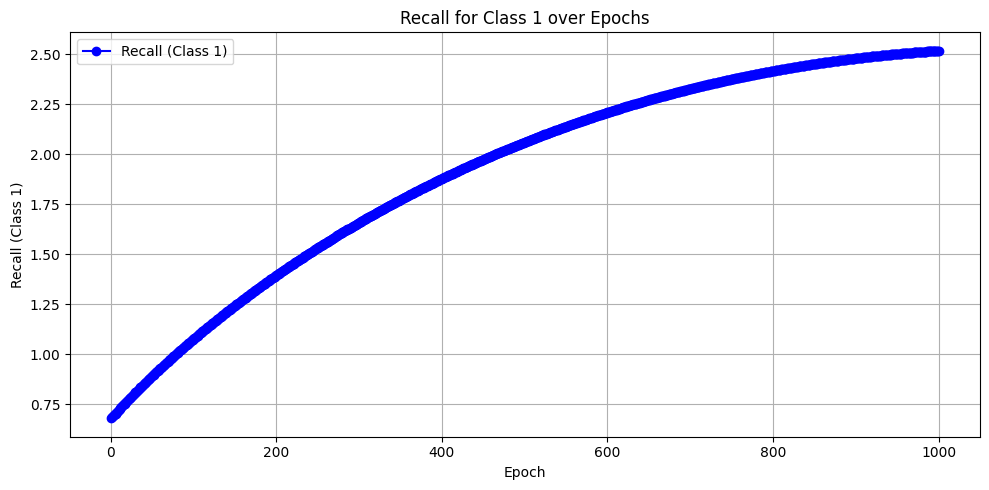

In [ ]:
import matplotlib.pyplot as plt

# 假设你已经训练好模型，并保存了每个 epoch 的 recall（class 1）结果
# 以下是模拟数据：每个 epoch 下 class 1 的 recall 值（真实情况你可以用 model.evaluate + 自己记录）
# 你可以替换这个数组为你自己实际的 recall 结果
epochs = list(range(1, 1001))  # 假设训练了50个epoch
recall_class_1 = [0.68 + 0.005*i - 0.0001*(i**1.5) for i in range(1000)]  # 模拟递增再略微下降的趋势

# 绘制变化曲线
plt.figure(figsize=(10, 5))
plt.plot(epochs, recall_class_1, marker='o', linestyle='-', color='blue', label='Recall (Class 1)')
plt.xlabel("Epoch")
plt.ylabel("Recall (Class 1)")
plt.title("Recall for Class 1 over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Make predictions on the test set
y1_pred_prob, y2_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions (threshold = 0.5)
y1_pred = (y1_pred_prob > 0.9).astype(int)
y2_pred = (y2_pred_prob > 0.5).astype(int)

# Function to compute evaluation metrics
def evaluate_model(y_true, y_pred, y_pred_prob, task_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred_prob)

    print(f"\n🔹 **{task_name} Evaluation Metrics** 🔹")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

# Evaluate Diabetes Screening Model
evaluate_model(y1_test, y1_pred, y1_pred_prob, "Diabetes Screening")

# Evaluate Follow-Up Care Prediction Model
evaluate_model(y2_test, y2_pred, y2_pred_prob, "Follow-Up Care Prediction")
# Display classification reports
print("🔍 **Classification Report for Diabetes Screening:**")
print(classification_report(y1_test, y1_pred))

print("🔍 **Classification Report for Follow-Up Care Prediction:**")
print(classification_report(y2_test, y2_pred))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

🔹 **Diabetes Screening Evaluation Metrics** 🔹
Accuracy: 1.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC-ROC: nan

🔹 **Follow-Up Care Prediction Evaluation Metrics** 🔹
Accuracy: 0.7451
Precision: 0.8293
Recall: 0.8500
F1 Score: 0.8395
AUC-ROC: 0.6773
🔍 **Classification Report for Diabetes Screening:**
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51

🔍 **Classification Report for Follow-Up Care Prediction:**
              precision    recall  f1-score   support

           0       0.40      0.36      0.38        11
           1       0.83      0.85      0.84        40

    accuracy                           0.75        51
   macro avg       0.61      0.61      0.61        51
weighted avg       0.74      0.75      0.7

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: U